# Notebook Intentions

The purpose of the notebook is to start exploring the types of utilization trends we can analyze with the new RespondentHistoryGenerator class. We will start off following utilization rates across years. At the time of generation only 2011-2018 data was accessible.

In [174]:
import os
from os.path import expanduser

import sys
sys.path.append(os.path.join(expanduser("~"), "meps", "meps_dev"))

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "meps_db.settings")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

import django
django.setup();

import random

import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np

from datetime import date
from dateutil.relativedelta import *
from scipy.stats import zscore
from statsmodels.stats.weightstats import DescrStatsW

from meps_db.components.reference import DATA_FILES_YEARS
from meps_db.processors import RespondentHistoryGenerator

In [2]:
rhg = RespondentHistoryGenerator(years=DATA_FILES_YEARS[:8])
respondent_history = rhg.run()

## Sample Patient Timeline

We want to build a function that will plot all the events in a respondent's year. This will help to illustrate the different types of respondents in the dataset.

The code below is about as good as we can get a dynamic timeline to perform. There are multiple challenges, as most respondent have very sparse timelines, yet we will likely be highlighting outlier timelines in the future. Additionally all event counts are treated equally, which affect the scatterplot point sizes. One month with many office based visits can make the entire timeline seem less impactful.

Note: presciption_medicines and other_medical utilization types are not currently linked to events so there are no dates associated with these events.

In [82]:
HIGH_UTILIZATION_SAMPLE = True
rng_year = random.choice(list(respondent_history.keys()))

if HIGH_UTILIZATION_SAMPLE:
    # enforce high utilization sample
    high_utils = []
    for resp_id, util_dict in respondent_history[rng_year].items():
        util_tracker = [
            len(util_list) for util_type, util_list in util_dict.items() 
            if util_type not in {"characteristics", "presciption_medicines", "other_medical"}
        ]
        if all(util_type_count > 0 for util_type_count in util_tracker):
            high_utils.append(resp_id)
    rng_resp = random.choice(high_utils)
else:
    rng_resp = random.choice(list(respondent_history[rng_year].keys()))
    


In [83]:
# aggregate events by date
date_tracker = {}
empty_util_types = []
for util_type, history in respondent_history[rng_year][rng_resp].items():
    if util_type in {"characteristics", "presciption_medicines", "other_medical"}:
        continue
    if len(history) > 0:
        for event in history:
            edate = event["date"]
            if edate not in date_tracker:
                date_tracker[edate] = {}
            if util_type not in date_tracker[edate]:
                date_tracker[edate][util_type] = 0
            date_tracker[edate][util_type] += 1
    else:
        empty_util_types.append(util_type)

# convert to list of dictionary
util_list = []
for date_obj, util_type_dict in date_tracker.items():
    for util_type, count in util_type_dict.items():
        util_list.append(
            {
                "date": date_obj,
                "util_type": util_type.replace("_" ," ").title(),
                "count": count,
            }
        )

for util_type in empty_util_types:
    util_list.append(
            {
                "date": date(year=rng_year, month=1, day=1),
                "util_type": util_type.replace("_" ," ").title(),
                "count": None,
            }
        )

        
# Enforce Order of Categories when plotting
util_df = pd.DataFrame(util_list)
util_df["util_type"] = pd.Categorical(
    util_df['util_type'],
    categories=[
        "Office Based",
        "Outpatient",
        "Emergency Room",
        "Hosptial Inpatient",
        "Home Health",
        "Dental Care",
    ],
    ordered=True
)
util_df.sort_values(["util_type"], inplace=True)
util_df.head(10)

,date,util_type,count
0,2012-01-01,Office Based,3
1,2012-05-01,Office Based,4
2,2012-03-01,Office Based,2
3,2012-06-01,Office Based,1
4,2012-08-01,Office Based,1
5,2012-11-01,Office Based,1
7,2012-12-01,Office Based,2
8,2012-12-01,Outpatient,1
9,2012-10-01,Emergency Room,1
10,2012-10-01,Hosptial Inpatient,1


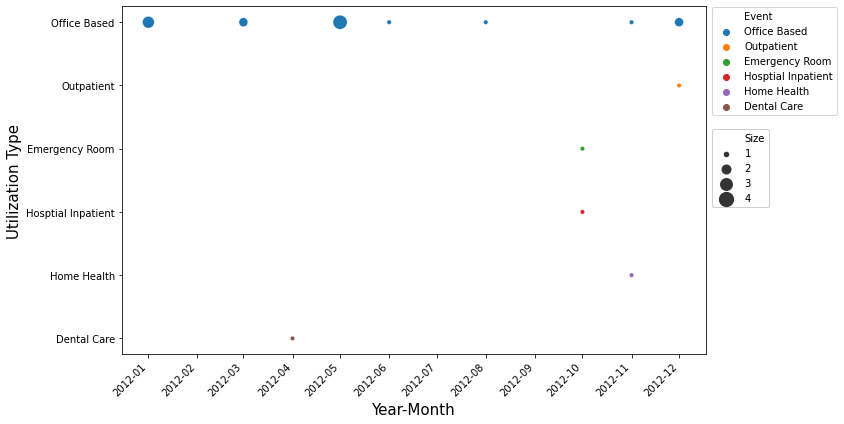

In [96]:
# Initialize

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    data=util_df, 
    x="date", 
    y="util_type", 
    hue="util_type", 
    size="count", 
    alpha=1,
    sizes = (20,200)
)

# Clean labels
plt.xticks(rotation=45)
ax.set_xlabel("Year-Month", fontsize=15)
# Enforce full year is visible 
tracker = []
start_date = date(year=rng_year, month=1, day=1)
for month in range(12):
    tracker.append(str(start_date+relativedelta(months=+month)))
tracker = [date_str[:7] for date_str in tracker]
ax.set(xticks=tracker)
ax.set_xticklabels(labels=tracker, rotation=45, ha='right')

ax.set_ylabel("Utilization Type", fontsize=15)

# split legends
handles, labels = ax.axes.get_legend_handles_labels()
clean_labels = [
    'Event',
    'Office Based',
    'Outpatient',
    'Emergency Room',
    'Hosptial Inpatient',
    'Home Health',
    'Dental Care',
]
fixed_labels, fixed_handles = [],[]
for label, handle in zip(clean_labels, handles):
    fixed_labels.append(label)
    fixed_handles.append(handle)
    
fixed_size_labels, fixed_size_handles = [],[]
for size, handle in zip(labels[len(clean_labels):], handles[len(clean_labels):]):
    fixed_size_labels.append(size)
    fixed_size_handles.append(handle)
fixed_size_labels[0] = "Size"
# Put the legends out of the figure
leg1 = plt.legend(fixed_handles, fixed_labels, bbox_to_anchor=(1.01, 1.), loc=2, borderaxespad=0.1)
leg2 = plt.legend(fixed_size_handles, fixed_size_labels, bbox_to_anchor=(1.01, .65), loc=2, borderaxespad=0.1)

ax.add_artist(leg1)
ax.add_artist(leg2)


# Display
plt.tight_layout()
plt.show()

## Average Population Utilization Per Year

We want to plot the average persons utilization across years. For this we will incorporate the "weight" variable of each respondent. We will experiment with different types of plots to determine which builds the clearest picture. One thing we want to handle is the distribution of data, we know that event's like ER visits are very rare but significant. The average number of ER visits will likely be close to zero, but we are likely going to be more interested in the number of ER visits for the 75% percentile.

In [121]:
def get_utilization_year(year, resp_id):
    """ Takes a year and a respondent id. Return a list of dictionaries. Each dictionary items contains a year, 
    a utilization type and the total number of events. """
    
    date_tracker = {}
    for util_type, history in respondent_history[year][resp_id].items():
        if util_type in {"characteristics", "presciption_medicines", "other_medical"}:
            continue
        if len(history) > 0:
            for event in history:
                if util_type not in date_tracker:
                    date_tracker[util_type] = 0
                date_tracker[util_type] += 1
        else:
            date_tracker[util_type] = 0

    # convert to list of dictionary
    util_list = []
    for util_type, count in date_tracker.items():
        util_list.append(
            {
                #"date": date_obj,
                "util_type": util_type.replace("_" ," ").title(),
                "count": count,
                "year": year,
                "weight": respondent_history[year][resp_id]["characteristics"]["weight"],

            }
        )
    return util_list


In [98]:
year = 2018
util_list = []
for resp_id in respondent_history[year]:
    util_list.extend(get_utilization_year(year=year, resp_id=resp_id))

# Enforce Order of Categories when plotting
util_df = pd.DataFrame(util_list)
util_df["util_type"] = pd.Categorical(
    util_df['util_type'],
    categories=[
        "Office Based",
        "Outpatient",
        "Emergency Room",
        "Hosptial Inpatient",
        "Home Health",
        "Dental Care",
    ],
    ordered=True
)
util_df.sort_values(["util_type"], inplace=True)
util_df.head(10)


,util_type,count,year,weight
0,Office Based,5,2018,19667.668164
128472,Office Based,2,2018,12309.479371
40722,Office Based,1,2018,12275.267322
128466,Office Based,2,2018,11720.411474
40728,Office Based,5,2018,6075.851624
128460,Office Based,0,2018,12163.645291
128454,Office Based,2,2018,5666.802837
40734,Office Based,2,2018,6981.546232
128448,Office Based,1,2018,6354.913130
40740,Office Based,6,2018,6256.303551


### Violin Plots

Violin plots are essentially a mix of KDEs and Box plots

We had hoped these would be useful for displaying transitions in utilization over years, but they are not well suited for this data. In most utilization types the overwhelming majority of respondents did not have an event during the year. This makes it such that the distribution is heavily left skewed. On the other hand, a small minority of respondents are heavy utilizers for an event type. This forces the Y axis to be very large, squishing the distribution down. Trying to compensate for both of these factors results in a conflict between relevance and readablility. We'll need to identify another type of plot. However violin plots may be useful when we start to evaluate spending. 

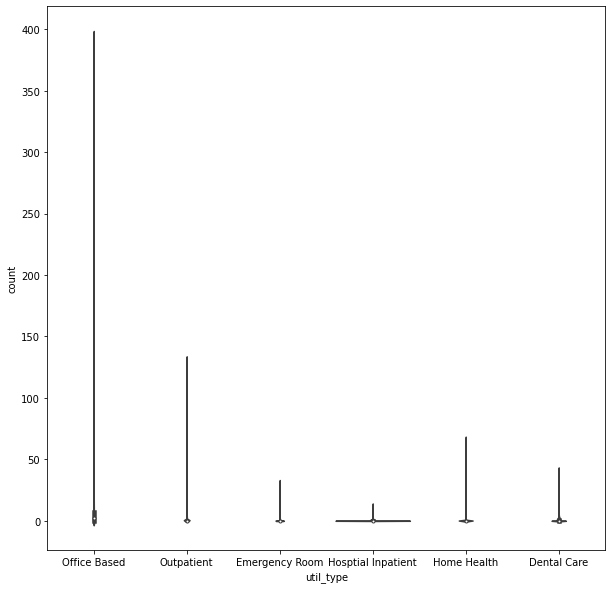

In [76]:
# Basic violinplot for 2018, unreadable due to extreme outliers such as the office based member
plt.figure(figsize=(10, 10))
ax = sns.violinplot(data=util_df, x="util_type", y="count")

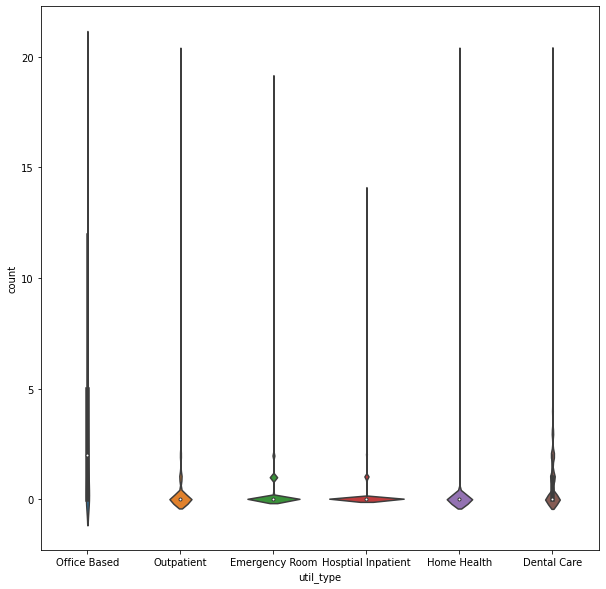

In [77]:
# filter out outliers
z_scores = zscore(util_df["count"])
abs_z_scores = np.abs(z_scores)
util_df["abs_z_scores"] = abs_z_scores

# Violin plot with lazy outlier removal, still dominated by extreme members
plt.figure(figsize=(10, 10))
ax = sns.violinplot(data=util_df.loc[(util_df["abs_z_scores"]<3)], x="util_type", y="count")

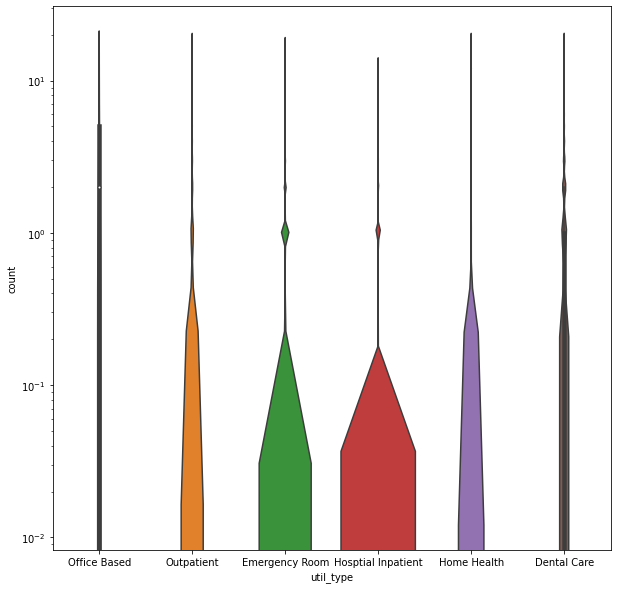

In [78]:

# filter out outliers
z_scores = zscore(util_df["count"])
abs_z_scores = np.abs(z_scores)
util_df["abs_z_scores"] = abs_z_scores

# Violin plot with lazy outlier removal, and logarithm scaling. Closer to what we want but the log scale make it
# less interpretable. However we can no identify some issues. Essentially most respondents have close to no 
# activity during a year except for office based visits.
plt.figure(figsize=(10, 10))
plt.yscale('log')
ax = sns.violinplot(data=util_df.loc[(util_df["abs_z_scores"]<3)], x="util_type", y="count")

In [99]:
util_df

,util_type,count,year,weight
0,Office Based,5,2018,19667.668164
128472,Office Based,2,2018,12309.479371
40722,Office Based,1,2018,12275.267322
128466,Office Based,2,2018,11720.411474
40728,Office Based,5,2018,6075.851624
...,...,...,...,...
132244,Dental Care,0,2018,9463.291736
37888,Dental Care,0,2018,12590.725902
132250,Dental Care,1,2018,9700.533041
132220,Dental Care,0,2018,10900.968618


## Facet Grids

Facet grids can be useful when stack graphs would create a lot of noise. However now it seems like the big probably is our distributions. The right skew is simple to long to display anything meaningful. A table of descriptive statistics seems like the best option at this point. 

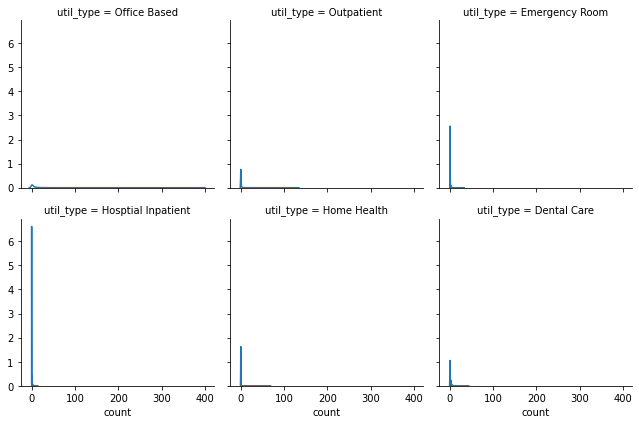

In [108]:
g = sns.FacetGrid(util_df, col="util_type", col_wrap=3, height=3)
g.map(sns.kdeplot, "count")

## Table

Using statsmodels we can quickly calculate weight statistics. We are able to generate a table that displays all utilization types, across years. We generate the following weighted statistics:

    - mean: average annual events
    - std: standard deviation of annual events
    - quantile_25: 25% of the population has x or less annual events 
    - quantile_50: 50% of the population has x or less annual events 
    - quantile_75: 75% of the population has x or less annual events 
    - quantile_95: 95% of the population has x or less annual events 

In [124]:
def get_utilization_year(year, resp_id):
    """ Takes a year and a respondent id. Return a list of dictionaries. Each dictionary items contains a year, 
    a utilization type and the total number of events. """
    
    date_tracker = {}
    for util_type, history in respondent_history[year][resp_id].items():
        if util_type in {"characteristics", "presciption_medicines", "other_medical"}:
            continue
        if len(history) > 0:
            for event in history:
                if util_type not in date_tracker:
                    date_tracker[util_type] = 0
                date_tracker[util_type] += 1
        else:
            date_tracker[util_type] = 0

    # convert to list of dictionary
    util_list = []
    for util_type, count in date_tracker.items():
        util_list.append(
            {
                #"date": date_obj,
                "util_type": util_type,
                "count": count,
                "year": year,
                "weight": respondent_history[year][resp_id]["characteristics"]["weight"],

            }
        )
    return util_list

In [130]:
annual_util_type = {}
for year in DATA_FILES_YEARS[:8]:
    util_list = []
    for resp_id in respondent_history[year]:
        util_list.extend(get_utilization_year(year=year, resp_id=resp_id))

    
    annual_util_type[year] = {}
    for resp_util in util_list:
        if resp_util["util_type"] not in annual_util_type[year]:
            annual_util_type[year][resp_util["util_type"]] = {"counts": [], "weights": []}
        annual_util_type[year][resp_util["util_type"]]["counts"].append(resp_util["count"])
        annual_util_type[year][resp_util["util_type"]]["weights"].append(resp_util["weight"])

In [169]:
annualized_data = []
for year in DATA_FILES_YEARS[:8]:
    for util_type in [
        "office_based",
        "outpatient",
        "emergency_room",
        "hosptial_inpatient",
        "home_health",
        "dental_care",
    ]:
        wdf = DescrStatsW(
            annual_util_type[year][util_type]["counts"], 
            weights=annual_util_type[year][util_type]["weights"], 
            ddof=1
        )
        annualized_data.append(
            {
                "year": year,
                "util_type": util_type,
                "mean": wdf.mean,
                "std": wdf.std,
                "quantile_25": list(wdf.quantile([0.25]))[0],
                "quantile_50": list(wdf.quantile([0.5]))[0],
                "quantile_75": list(wdf.quantile([0.75]))[0],
                "quantile_95": list(wdf.quantile([0.95]))[0],
            }
        )
annualized_df = pd.DataFrame(annualized_data)
annualized_df.sort_values(["util_type", "year"], ascending=False, inplace=True)
annualized_df.reset_index(inplace=True, drop=True)

In [170]:
annualized_df

,year,util_type,mean,std,quantile_25,quantile_50,quantile_75,quantile_95
0,2018,outpatient,0.623419,3.196282,0,0,0,3
1,2017,outpatient,0.528420,2.783053,0,0,0,2
2,2016,outpatient,0.482435,2.578995,0,0,0,2
3,2015,outpatient,0.490824,2.431790,0,0,0,2
4,2014,outpatient,0.529372,2.791998,0,0,0,2
5,2013,outpatient,0.437136,2.241141,0,0,0,2
6,2012,outpatient,0.384746,2.352293,0,0,0,2
7,2011,outpatient,0.420477,2.525145,0,0,0,2
8,2018,office_based,6.391976,13.317598,1,2,7,26
9,2017,office_based,5.784107,11.720768,0,2,6,24
